# Compare sDMD to ICA and gICA


### Before running this notebook:

**Download ICA Data:**

We use the gICA/dual regression results provided by the HCP. These are not downloaded automatically by our download scripts, but can be downloaded directly from <a href="https://db.humanconnectome.org">ConnectomeDB</a>.

At the time of publication, this dataset can be acquired as follows: log in to ConnectomeDB and locate the "WU-Minn HCP Data - 1200 subjects" dataset, then click the "Open Dataset" button. Within the "Resources" tab, locate the list of "Subject-specific ICA parcellations (node maps)", then download the set "CIFTI Subject-specific Parcellations for 15-,25-,5-, 100-dimensionalities (65GB)", as pictured below:
<img src="./notebook_media/gICA_data_download.png" alt="Drawing" style="width: 384px;"/>

This will download a zip file which will include the subject-level gICA parcellations. We use the 15-dimensional results as located in the folder '3T_HCP1200_MSMAll_d15_ts2_Z'. Change the 'icadir' variable below to match this folder location.

**Run DMD:**

This notebook uses the DMD results calculated in the previous notebook "1_Calculate_DMD". We assume below that the script has been run with the default parameters: specifically, we assume that all four sets of scans have been analyzed (REST1_LR,REST1_RL,REST2_LR,REST2_RL), extracting 8 modes per window with a window length of 32.

In [1]:
%load_ext watermark
%watermark -a "James Kunert-Graf" -d -v -m -p os,time,copy,h5py,tqdm,scipy,numpy,matplotlib,sklearn,nibabel,pandas,seaborn -g -u

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


James Kunert-Graf 
last updated: 2018-04-30 

CPython 2.7.12
IPython 5.6.0

os n
time n
copy n
h5py 2.7.0
tqdm 4.11.2
scipy 1.0.0
numpy 1.14.2
matplotlib 2.0.2
sklearn 0.18
nibabel 2.1.0
pandas 0.22.0
seaborn 0.7.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-121-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : c52e822031f5725d9d8fe706b4724596f5f08b36


In [2]:
import os,time,copy
import h5py
from tqdm import tqdm_notebook as tqdm
import scipy as sci
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import nibabel as nib
import pandas as pd
import seaborn as sns

from DMD import DMD
from hcp_dmd_utils import loadGrayord,binCortexData,mat2flat,flat2mat
%matplotlib inline

# Load gICA Modes

In [3]:
u120=np.genfromtxt('./u120.txt').astype(int).astype(str)
ulist=u120

datadir='/hdd/HCP_DMD/HCP_DMD/data/'
icadir='/hdd/HCP_DMD/HCP_DMD/ICA/3T_HCP1200_MSMAll_d15_ts2_Z/'
DMN_ICA=[]
for u in tqdm(ulist):
    data=nib.load(icadir+'{:}.dtseries.nii'.format(u))
    data=np.array(data.get_data())[0,0,0,0,:,:]
    IC=binCortexData(data.T)[:,1]
    IC=(IC-IC.mean())/IC.std()
    DMN_ICA.append(IC)
DMN_ICA=np.vstack(DMN_ICA)

HBox(children=(IntProgress(value=0, max=120), HTML(value=u'')))

# Run sDMD

The cell below iterates through subjects and collects together the DMD results for all four of their scans. Clustering is done identically as to previous notebooks (see 2_Calculate_Clusters-sDMD notebook for more detail on how clustering is performed). There is one additional step in this implementation: the optimal choice of clustering parameters may vary from scan to scan (specifically the z-threshold for pre-cluster filtering and threshold value for forming flat clusters). Accordingly, we run sDMD on a grid of these parameters, and use the output cluster which best resembles the DMN.

In [4]:
#%% EXPERIMENT TO GET BEST PARAMETERS FOR EXTRACTING DMN
scandirs=['LR','RL']
runlabels=['REST1','REST2']
nmodes=8
nframes=32


mthresh=25
min_clust_size=5

zthreshes=np.linspace(1.5,3,61)
fct_list=np.linspace(0.65,0.98,101)

try:
    os.mkdir('./sDMDvGICA')
except:
    pass
try:
    os.mkdir('./sDMDvGICA/params')
except:
    pass

with h5py.File('./RSN.h5','r') as hf:
  RSNs=np.array(hf['RSNs'])
  RSNlabels=np.array(hf['RSNlabels'])
rsn=[]        
for k in range(RSNs.shape[2]):
  r=RSNs[:,:,k]
  rsn.append(mat2flat(r))
rsn=np.vstack(rsn)
rsnNo=[3,4,9,13]
rsn=rsn[rsnNo,:]
rlabs=RSNlabels[rsnNo] 


for uk,u in enumerate(ulist):
  print(u)
  try:
    icak=DMN_ICA[uk]
    dmn_best=[]
    Cor=np.zeros((len(zthreshes),len(fct_list)))
    F=[]
    T=[]
    try:
      for runlabel in runlabels:
        for scandir in scandirs:
          fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
          with h5py.File(fdir+'Modes_{:}.h5'.format(u),'r') as hf:
            F.append(np.array(hf['F']))
    except:
      pass
      
    
    F=np.vstack(F)
    
    Mflat=(F-np.mean(F,1)[:,None])/F.std(1)[:,None]
     
    mpro=[]
    for f in Mflat:
      m=flat2mat(f>2.0).astype(float)
      mpro.append(np.sum(np.sum(m[1:,1:]*m[:-1,:-1],0),0))
    mpro=np.hstack(mpro) 
     
    mwhere=mpro>mthresh
    
    Fz=F[mwhere,:]
    Fz=(Fz-np.mean(Fz,1)[:,None])/np.std(Fz,1)[:,None]
    
    for i,zthresh in enumerate(tqdm(zthreshes)):
      Fn=(Fz>zthresh).astype(float)
      method='average';metric='correlation';
      
      Z=sch.linkage(Fn, method, metric)
      ix=sch.dendrogram(Z,no_plot=True)['leaves']  
      for j,fclust_thresh in enumerate(fct_list):
        try:
          cgroups=sch.fcluster(Z,fclust_thresh,'distance')[ix]
          cgroups=cgroups.astype(float)
          cun,count=np.unique(cgroups,return_counts=True)
          for k,c in enumerate(cun):
              if count[k]<min_clust_size:
                  cgroups[cgroups==c]=-1
                  
          cgroups=np.unique(cgroups,return_inverse=True)[1].astype(float)
          cgroups[cgroups==0]=np.nan
          cgroups+=-1
          
          cif=np.isfinite(cgroups)
          cuni=np.unique(cgroups[cif])
          
          cbig=np.ones(cgroups.shape)*np.nan
          ck=-1
          for c in cuni:
              if np.sum(cgroups==c)>1:
                  ck+=1
                  cbig[cgroups==c]=ck
          
          glist=np.unique(cgroups[np.isnan(cgroups)==False]).astype(int)
          
          modes=F[mwhere][ix][cif]
          
          moda=[]
          for c in cuni:
            moc=modes[cbig[cif]==c].mean(0)
            moc=(moc-moc.mean())/moc.std()
            moda.append(moc)
            
          moda=np.vstack(moda)
         
          dmn=moda[np.argmax(np.corrcoef(rsn[0],moda)[0][1:])]
          cscore=np.corrcoef(dmn,icak)[0][1]

          Cor[i,j]=cscore
          
          if cscore==Cor.max():
            dmn_best=copy.copy(dmn)
            fc_best=copy.copy(fclust_thresh)
            zthresh_best=copy.copy(zthresh)
        except:
          pass

    Db=(dmn_best-dmn_best.mean())/dmn_best.std()
    Db=flat2mat(Db)
    Db[Db==0]=np.nan  
    Ik=(icak-icak.mean())/icak.std()
    Ik=flat2mat(Ik)
    Ik[Ik==0]=np.nan

    Cpop=list(np.corrcoef(dmn_best,DMN_ICA)[0,1:])
    Csub=Cpop.pop(uk)
    Cpop=np.array(Cpop)
    
    with h5py.File('./sDMDvGICA/params/{:}.h5'.format(u),'w') as hf:
      hf.create_dataset('Cor',data=Cor)
      hf.create_dataset('zthreshes',data=zthreshes)
      hf.create_dataset('fct_list',data=fct_list)
      hf.create_dataset('mthresh',data=mthresh)
      hf.create_dataset('Db',data=Db)
      hf.create_dataset('Ik',data=Ik)
      hf.create_dataset('dmn',data=dmn_best)
      hf.create_dataset('Cpop',data=Cpop)
      hf.create_dataset('Csub',data=Csub)
      hf.create_dataset('uk',data=uk)
      hf.create_dataset('fc_best',data=fc_best)
      hf.create_dataset('zthresh_best',data=zthresh_best)

  except (KeyboardInterrupt, SystemExit):
    raise
  except:
    raise
    

102513


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


104012


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


104416


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


107321


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


107422


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


109123


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


112516


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


114217


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


118124


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


118225


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


122822


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


123925


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


130619


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


131217


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


131722


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


136732


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


137229


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


137633


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


145127


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


148335


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


149842


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


151425


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


152831


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


154936


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


155938


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


157437


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


157942


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


158843


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


164030


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


164131


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


166438


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


167036


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


167238


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


168240


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


171633


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


172029


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


173940


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


177241


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


178950


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


179245


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


179346


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


180432


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


180937


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


181636


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


185341


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


185442


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


189450


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


191336


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


192843


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


194746


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


195041


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


195849


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


195950


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


198249


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


198350


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


198855


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


200008


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


200311


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


201414


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


204319


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


207123


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


209228


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


211316


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


211922


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


212116


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


223929


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


227432


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


268850


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


285345


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


303119


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


308331


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


309636


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


311320


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


316633


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


316835


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


330324


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


339847


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


346945


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


352132


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


381543


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


397154


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


432332


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


433839


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


436239


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


456346


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


459453


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


479762


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


500222


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


512835


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


562345


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


571144


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


580751


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


587664


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


611938


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


627852


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


645450


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


660951


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


667056


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


677766


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


687163


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


690152


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


700634


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


735148


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


769064


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


783462


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


789373


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


803240


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


816653


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


820745


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


833148


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


837964


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


841349


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


877269


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


907656


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


922854


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


952863


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


955465


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


965367


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


987983


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))


993675


HBox(children=(IntProgress(value=0, max=61), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


102513, [8, 10, 12, 16] modes: 0.345/0.287
Time elapsed is 561.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


104012, [8, 10, 12, 16] modes: 0.462/0.361
Time elapsed is 549.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


104416, [8, 10, 12, 16] modes: 0.069/0.043
Time elapsed is 549.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


107321, [8, 10, 12, 16] modes: 0.470/0.373
Time elapsed is 566.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


107422, [8, 10, 12, 16] modes: 0.554/0.416
Time elapsed is 547.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


109123, [8, 10, 12, 16] modes: 0.103/0.076
Time elapsed is 546.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


112516, [8, 10, 12, 16] modes: 0.491/0.358
Time elapsed is 548.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


114217, [8, 10, 12, 16] modes: 0.531/0.461
Time elapsed is 548.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


118124, [8, 10, 12, 16] modes: 0.374/0.316
Time elapsed is 550.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


118225, [8, 10, 12, 16] modes: 0.495/0.354
Time elapsed is 549.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


122822, [8, 10, 12, 16] modes: 0.313/0.263
Time elapsed is 550.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


123925, [8, 10, 12, 16] modes: 0.511/0.439
Time elapsed is 549.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


130619, [8, 10, 12, 16] modes: 0.563/0.441
Time elapsed is 550.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


131217, [8, 10, 12, 16] modes: 0.299/0.238
Time elapsed is 548.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


131722, [8, 10, 12, 16] modes: 0.107/0.052
Time elapsed is 547.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


136732, [8, 10, 12, 16] modes: 0.411/0.323
Time elapsed is 547.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


137229, [8, 10, 12, 16] modes: 0.330/0.341
Time elapsed is 551.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


137633, [8, 10, 12, 16] modes: 0.586/0.454
Time elapsed is 548.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


145127, [8, 10, 12, 16] modes: 0.105/0.124
Time elapsed is 548.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


148335, [8, 10, 12, 16] modes: 0.431/0.386
Time elapsed is 547.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


149842, [8, 10, 12, 16] modes: 0.471/0.432
Time elapsed is 549.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


151425, [8, 10, 12, 16] modes: 0.598/0.443
Time elapsed is 549.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


152831, [8, 10, 12, 16] modes: 0.301/0.233
Time elapsed is 548.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


154936, [8, 10, 12, 16] modes: 0.529/0.421
Time elapsed is 546.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


155938, [8, 10, 12, 16] modes: 0.400/0.367
Time elapsed is 599.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


157437, [8, 10, 12, 16] modes: 0.312/0.265
Time elapsed is 632.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


157942, [8, 10, 12, 16] modes: 0.376/0.288
Time elapsed is 548.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


158843, [8, 10, 12, 16] modes: 0.419/0.378
Time elapsed is 549.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


164030, [8, 10, 12, 16] modes: 0.190/0.163
Time elapsed is 550.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


164131, [8, 10, 12, 16] modes: 0.263/0.235
Time elapsed is 550.8 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


166438, [8, 10, 12, 16] modes: 0.291/0.326
Time elapsed is 551.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


167036, [8, 10, 12, 16] modes: 0.468/0.403
Time elapsed is 551.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


167238, [8, 10, 12, 16] modes: 0.519/0.456
Time elapsed is 547.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


168240, [8, 10, 12, 16] modes: 0.358/0.312
Time elapsed is 546.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


171633, [8, 10, 12, 16] modes: 0.425/0.303
Time elapsed is 548.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


172029, [8, 10, 12, 16] modes: 0.558/0.473
Time elapsed is 548.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


173940, [8, 10, 12, 16] modes: 0.578/0.477
Time elapsed is 549.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


177241, [8, 10, 12, 16] modes: 0.356/0.268
Time elapsed is 549.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


178950, [8, 10, 12, 16] modes: 0.393/0.373
Time elapsed is 551.8 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


179245, [8, 10, 12, 16] modes: 0.139/0.094
Time elapsed is 583.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


179346, [8, 10, 12, 16] modes: 0.485/0.424
Time elapsed is 557.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


180432, [8, 10, 12, 16] modes: 0.530/0.440
Time elapsed is 548.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


180937, [8, 10, 12, 16] modes: 0.494/0.406
Time elapsed is 550.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


181636, [8, 10, 12, 16] modes: 0.062/0.048
Time elapsed is 549.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


185341, [8, 10, 12, 16] modes: 0.460/0.349
Time elapsed is 547.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


185442, [8, 10, 12, 16] modes: 0.385/0.321
Time elapsed is 571.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


189450, [8, 10, 12, 16] modes: 0.242/0.226
Time elapsed is 618.8 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


191336, [8, 10, 12, 16] modes: 0.476/0.350
Time elapsed is 547.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


192843, [8, 10, 12, 16] modes: 0.354/0.312
Time elapsed is 599.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


194746, [8, 10, 12, 16] modes: 0.476/0.384
Time elapsed is 576.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


195041, [8, 10, 12, 16] modes: 0.404/0.301
Time elapsed is 607.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


195849, [8, 10, 12, 16] modes: 0.333/0.240
Time elapsed is 583.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


195950, [8, 10, 12, 16] modes: 0.330/0.364
Time elapsed is 578.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


198249, [8, 10, 12, 16] modes: 0.167/0.102
Time elapsed is 560.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


198350, [8, 10, 12, 16] modes: 0.262/0.240
Time elapsed is 576.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


198855, [8, 10, 12, 16] modes: 0.485/0.412
Time elapsed is 597.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


200008, [8, 10, 12, 16] modes: 0.518/0.392
Time elapsed is 578.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


200311, [8, 10, 12, 16] modes: 0.604/0.457
Time elapsed is 607.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


201414, [8, 10, 12, 16] modes: 0.116/0.089
Time elapsed is 606.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


204319, [8, 10, 12, 16] modes: 0.499/0.395
Time elapsed is 603.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


207123, [8, 10, 12, 16] modes: 0.145/0.142
Time elapsed is 630.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


209228, [8, 10, 12, 16] modes: 0.315/0.227
Time elapsed is 563.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


211316, [8, 10, 12, 16] modes: 0.460/0.375
Time elapsed is 578.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:58: RuntimeWarning: invalid value encountered in sqrt
  return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


211922, [8, 10, 12, 16] modes: 0.086/0.077
Time elapsed is 566.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


212116, [8, 10, 12, 16] modes: 0.467/0.396
Time elapsed is 562.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


223929, [8, 10, 12, 16] modes: 0.064/0.025
Time elapsed is 574.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


227432, [8, 10, 12, 16] modes: 0.418/0.373
Time elapsed is 587.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


268850, [8, 10, 12, 16] modes: 0.543/0.424
Time elapsed is 548.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


285345, [8, 10, 12, 16] modes: 0.490/0.404
Time elapsed is 577.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


303119, [8, 10, 12, 16] modes: 0.126/0.102
Time elapsed is 549.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


308331, [8, 10, 12, 16] modes: 0.043/0.052
Time elapsed is 542.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


309636, [8, 10, 12, 16] modes: 0.452/0.409
Time elapsed is 546.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


311320, [8, 10, 12, 16] modes: 0.247/0.214
Time elapsed is 556.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


316633, [8, 10, 12, 16] modes: 0.470/0.374
Time elapsed is 544.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


316835, [8, 10, 12, 16] modes: 0.536/0.453
Time elapsed is 551.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


330324, [8, 10, 12, 16] modes: 0.430/0.331
Time elapsed is 542.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


339847, [8, 10, 12, 16] modes: 0.541/0.453
Time elapsed is 562.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


346945, [8, 10, 12, 16] modes: 0.463/0.365
Time elapsed is 545.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


352132, [8, 10, 12, 16] modes: 0.261/0.209
Time elapsed is 545.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


381543, [8, 10, 12, 16] modes: 0.375/0.370
Time elapsed is 540.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


397154, [8, 10, 12, 16] modes: 0.428/0.362
Time elapsed is 543.5 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


432332, [8, 10, 12, 16] modes: 0.512/0.414
Time elapsed is 546.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


433839, [8, 10, 12, 16] modes: 0.485/0.393
Time elapsed is 544.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


436239, [8, 10, 12, 16] modes: 0.396/0.316
Time elapsed is 542.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


456346, [8, 10, 12, 16] modes: 0.410/0.363
Time elapsed is 158.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


459453, [8, 10, 12, 16] modes: 0.396/0.275
Time elapsed is 540.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


479762, [8, 10, 12, 16] modes: 0.503/0.413
Time elapsed is 556.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


500222, [8, 10, 12, 16] modes: 0.428/0.341
Time elapsed is 542.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


512835, [8, 10, 12, 16] modes: 0.100/0.094
Time elapsed is 547.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


562345, [8, 10, 12, 16] modes: 0.616/0.427
Time elapsed is 551.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


571144, [8, 10, 12, 16] modes: 0.527/0.434
Time elapsed is 542.8 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


580751, [8, 10, 12, 16] modes: 0.478/0.416
Time elapsed is 575.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


587664, [8, 10, 12, 16] modes: 0.564/0.487
Time elapsed is 544.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


611938, [8, 10, 12, 16] modes: 0.172/0.128
Time elapsed is 572.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


627852, [8, 10, 12, 16] modes: 0.464/0.383
Time elapsed is 544.8 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


645450, [8, 10, 12, 16] modes: 0.406/0.334
Time elapsed is 545.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


660951, [8, 10, 12, 16] modes: 0.539/0.476
Time elapsed is 546.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


667056, [8, 10, 12, 16] modes: 0.358/0.312
Time elapsed is 545.8 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


677766, [8, 10, 12, 16] modes: 0.578/0.443
Time elapsed is 544.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


687163, [8, 10, 12, 16] modes: 0.394/0.347
Time elapsed is 546.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


690152, [8, 10, 12, 16] modes: 0.541/0.432
Time elapsed is 545.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


700634, [8, 10, 12, 16] modes: 0.441/0.341
Time elapsed is 546.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


735148, [8, 10, 12, 16] modes: 0.318/0.242
Time elapsed is 546.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


769064, [8, 10, 12, 16] modes: 0.106/0.023
Time elapsed is 546.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


783462, [8, 10, 12, 16] modes: 0.106/0.023
Time elapsed is 545.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


789373, [8, 10, 12, 16] modes: 0.532/0.424
Time elapsed is 567.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


803240, [8, 10, 12, 16] modes: 0.447/0.388
Time elapsed is 549.4 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


816653, [8, 10, 12, 16] modes: 0.410/0.257
Time elapsed is 544.0 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


820745, [8, 10, 12, 16] modes: 0.464/0.377
Time elapsed is 545.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


833148, [8, 10, 12, 16] modes: 0.088/0.084
Time elapsed is 546.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


837964, [8, 10, 12, 16] modes: 0.554/0.452
Time elapsed is 555.3 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


841349, [8, 10, 12, 16] modes: 0.546/0.430
Time elapsed is 542.7 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


877269, [8, 10, 12, 16] modes: 0.536/0.432
Time elapsed is 546.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


907656, [8, 10, 12, 16] modes: 0.197/0.175
Time elapsed is 545.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


922854, [8, 10, 12, 16] modes: 0.296/0.216
Time elapsed is 542.1 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


952863, [8, 10, 12, 16] modes: 0.538/0.467
Time elapsed is 578.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


955465, [8, 10, 12, 16] modes: 0.212/0.200
Time elapsed is 545.6 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


965367, [8, 10, 12, 16] modes: 0.491/0.357
Time elapsed is 544.2 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


987983, [8, 10, 12, 16] modes: 0.299/0.200
Time elapsed is 544.9 seconds


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


993675, [8, 10, 12, 16] modes: 0.510/0.400
Time elapsed is 546.0 seconds


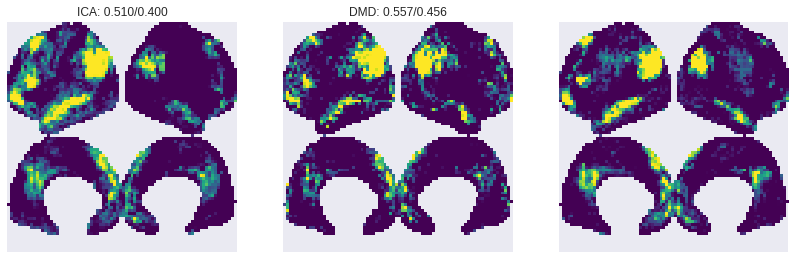

In [5]:
flag='_best_spatial'

scandirs=['LR','RL']
runlabels=['REST1','REST2']
nmodes=[8,10,12,16]

for uk,u in enumerate(ulist):
 if os.path.isfile('./sDMDvGICA/params/ica_{:}{:}.png'.format(u,flag)):
  print '{:} already calculated!'.format(u)
 else:
  tic=time.time()
  X=[]
  for runlabel in runlabels:
    for scandir in scandirs:
      try:
        fname=datadir+u+'/rfMRI_'+runlabel+'_'+scandir+'_Atlas.dtseries.nii'
        X.append(loadGrayord(fname)[:59412])
      except:
        pass
  X=np.hstack(X)
  bestcscore=0.0
  nica=3
  for nk in tqdm(range(nica)):
    try:
      ica=FastICA(np.random.choice(nmodes),max_iter=1000).fit_transform(X)
      
      
      I=binCortexData(ica)
      I=(I-I.mean(0)[None,:])/I.std(0)[None,:]
      cscore_list=np.corrcoef((DMN_ICA[uk]>2).astype(float),(I.T>2).astype(float))[0,1:]
      cscore=np.max(cscore_list)
      
      if cscore>bestcscore:
        bestcscore=cscore
        icadmn=I[:,np.argmax(cscore_list)]
        icadmn=(icadmn-icadmn.mean())/icadmn.std()       
        Cpop=list(np.corrcoef((icadmn>2.0).astype(float),(DMN_ICA>2.0).astype(float))[0,1:])
        Csub=Cpop.pop(uk)
        Cpop=np.array(Cpop)
        
    
    except:
      pass
    
  with h5py.File('./sDMDvGICA/params/{:}.h5'.format(u),'r') as hf:
    #dmd_Cpop=np.array(hf['Cpop'])
    #dmd_Csub=np.array(hf['Csub'])
    D=np.array(hf['Db'])
    GI=np.array(hf['Ik'])
    
  dmddmn=mat2flat(D)
  
  dmd_cpop=list(np.corrcoef((dmddmn>2.0).astype(float),(DMN_ICA>2.0).astype(float))[0,1:])
  dmd_csub=dmd_cpop.pop(uk)
  dmd_cpop=np.array(dmd_cpop)
  
  with h5py.File('./sDMDvGICA/params/{:}_ica{:}.h5'.format(u,flag),'w') as hf:
    hf.create_dataset('Csub_ica',data=Csub)
    hf.create_dataset('Cpop_ica',data=Cpop)
    hf.create_dataset('Csub_dmd',data=dmd_csub)
    hf.create_dataset('Cpop_dmd',data=dmd_cpop)
    hf.create_dataset('icadmn',data=icadmn)
    hf.create_dataset('nmodes',data=nmodes)

  
  
  I=flat2mat(icadmn)
  I[I==0.0]=np.nan
  #%
  plt.close('all')
  plt.figure(figsize=(14,5))
  #plt.get_current_fig_manager().window.setGeometry(295, 260, 1418, 554)
  plt.subplot(1,3,1)
  plt.imshow(I,vmin=0,vmax=2,cmap='viridis')
  plt.title('ICA: {:0.3f}/{:0.3f}'.format(Csub,Cpop.mean()))
  plt.xticks([]);plt.yticks([]);
  plt.subplot(1,3,2)
  plt.imshow(D,vmin=0,vmax=2,cmap='viridis')
  plt.title('DMD: {:0.3f}/{:0.3f}'.format(float(dmd_csub),dmd_cpop.mean()))
  plt.xticks([]);plt.yticks([]);
  plt.subplot(1,3,3)
  plt.imshow(GI,vmin=0,vmax=2,cmap='viridis')
  plt.xticks([]);plt.yticks([])
  
  plt.savefig('./sDMDvGICA/params/ica_{:}{:}.png'.format(u,flag))
  print '{:}, {:} modes: {:0.3f}/{:0.3f}'.format(u,nmodes,Csub,Cpop.mean())
  print 'Time elapsed is {:0.1f} seconds'.format(time.time()-tic)
  
  

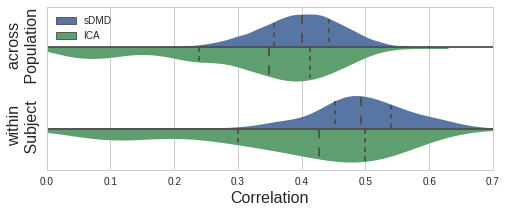

In [8]:

ica_pop=[];ica_sub=[]
dmd_pop=[];dmd_sub=[]
for u in ulist:
  try:
    with h5py.File('./sDMDvGICA/params/{:}_ica_best_spatial.h5'.format(u),'r') as hf:
      ica_pop.append(np.array(hf['Cpop_ica']))
      ica_sub.append(np.array(hf['Csub_ica']))
      dmd_pop.append(np.array(hf['Cpop_dmd']))
      dmd_sub.append(np.array(hf['Csub_dmd']))
  except:
    pass
dmd_pop=np.hstack(dmd_pop)
dmd_sub=np.hstack(dmd_sub)
ica_pop=np.hstack(ica_pop)
ica_sub=np.hstack(ica_sub)

dlist=[dmd_pop,dmd_sub,ica_pop,ica_sub]
dlabs=np.hstack([k*np.ones(len(d)) for k,d in enumerate(dlist)]).astype(int)
data=np.hstack(dlist)
is_ica=np.array(dlabs>=2).astype(int)
icatabs=np.array(['sDMD','ICA'])
is_ica=icatabs[is_ica]

dlt=['Across Population','Within Same Subject']
dlabtabs=np.array(dlt*2)
dlabs=dlabtabs[dlabs]

corlab='Correlation of DMD/ICA DMNs with gICA DMNs'

df=pd.DataFrame.from_dict({'popcompare':dlabs,corlab:data,'isICA':is_ica})

sns.set_style('whitegrid')
plt.close('all')
plt.figure(figsize=(8,3))
plt.plot([0,0.7],[0,0],c=[0.3,0.3,0.3])
plt.plot([0,0.7],[1,1],c=[0.3,0.3,0.3])
g=sns.violinplot(data=df,y='popcompare',x=corlab,hue='isICA',inner='quartile',split=True,legend_out=True,scale='width')
leg=g.axes.get_legend()
leg.set_title('');leg._loc=2

plt.xlim([0,0.7])
plt.yticks([0,1],['across   \n Population','within \n Subject'],rotation=90,va='center',size=16)
plt.ylabel('')
plt.xlabel('Correlation',size=16)

###SAVE
plt.savefig('./sDMDvGICA/Distributions.svg')
